### Data Parsing in R

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("Biostrings")

library(Biostrings)

(as ‘lib’ is unspecified)




A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages 




Error in library(Biostrings) : there is no package called ‘Biostrings’


In [ ]:
%%R
#install.packages("R.utils")
#install.packages("mildsvm")
install.packages("e1071")
install.packages("ROSE")


In [ ]:
%%R
library(jsonlite)
library(stringr)
library(R.utils)
library(dplyr)

# gunzip("drive/MyDrive/dataset0.json.gz", remove = F)

df <- bind_rows(lapply(readLines("drive/MyDrive/dataset0.json"), function(line) {
  temp <- as.data.frame(jsonlite::fromJSON(line))
  info <- str_split(colnames(temp)[1], pattern = "\\.")[[1]]
  transcript_id <- info[1]
  pos_no <- info[2]
  sequence <- info[3]
  read_id <- seq(1, nrow(temp))

  temp <- cbind(read_id, transcript_id, pos_no, sequence, temp)
  colnames(temp)[5:13] <- c("dwelling_t-1", "sd_-1", "mean_-1",
                            "dwelling_t0", "sd_0", "mean_0",
                            "dwelling_t1", "sd_1", "mean_1")
  return(temp)
}))

write.csv(df, file = "dataset.csv", row.names = F)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%%R
library(tidyverse)

df <- read.csv("drive/MyDrive/dataset.csv")
info <- read.csv("drive/MyDrive/data.info")


In [ ]:
%%R

colnames(df)[3] <- "transcript_position"

full_df <- left_join(df, info, by = c("transcript_id", "transcript_position"))



In [ ]:
%%R

library(mildsvm)

full_df_bag <- full_df %>%
                mutate(id_pos = paste(transcript_id, transcript_position))

fit <- omisvm(mi(label, id_pos) ~ dwelling_t.1 + sd_.1 + mean_.1 + dwelling_t0 + sd_0 + mean_0 + dwelling_t1 + sd_1 + mean_1, data = full_df_bag, weights = NULL)
print(fit)

In [ ]:
%%R

head(full_df)

  read_id   transcript_id transcript_position sequence dwelling_t.1 sd_.1
1       1 ENST00000000233                 244  AAGACCA      0.00299  2.06
2       2 ENST00000000233                 244  AAGACCA      0.00631  2.53
3       3 ENST00000000233                 244  AAGACCA      0.00465  3.92
4       4 ENST00000000233                 244  AAGACCA      0.00398  2.06
5       5 ENST00000000233                 244  AAGACCA      0.00664  2.92
6       6 ENST00000000233                 244  AAGACCA      0.01030  3.83
  mean_.1 dwelling_t0  sd_0 mean_0 dwelling_t1  sd_1 mean_1         gene_id
1     125     0.01770 10.40    122     0.00930 10.90   84.1 ENSG00000004059
2     125     0.00844  4.67    126     0.01030  6.30   80.9 ENSG00000004059
3     109     0.01360 12.00    124     0.00498  2.13   79.6 ENSG00000004059
4     125     0.00830  5.01    130     0.00498  3.78   80.4 ENSG00000004059
5     120     0.00266  3.94    129     0.01300  7.15   82.2 ENSG00000004059
6     123     0.00598  6.4

In [ ]:
%%R

full_df %>%
  mutate(label = as.factor(label)) %>%
  group_by(transcript_id, transcript_position, gene_id, label) %>%
  summarise(across(`dwelling_t.1`:mean_1, mean)) -> agg_full_df

`summarise()` has grouped output by 'transcript_id', 'transcript_position',
'gene_id'. You can override using the `.groups` argument.


In [ ]:
%%R

sample <- full_df[1:20000,]
sample %>%
  group_by(transcript_id, transcript_position, gene_id, label) %>%
  summarise(across(`dwelling_t.1`:mean_1, mean)) -> agg_full_df

`summarise()` has grouped output by 'transcript_id', 'transcript_position',
'gene_id'. You can override using the `.groups` argument.


In [ ]:
%%R

gene_set <- unique(agg_full_df$gene_id)
n_gene <- length(gene_set)

train_set <- sample(1:n_gene, floor(0.7*n_gene))
train_gene <- gene_set[train_set]

df_train <- agg_full_df %>%
              filter(gene_id %in% train_gene)
df_test <- agg_full_df %>%
              filter(!(gene_id %in% train_gene))



In [ ]:
%%R

head(agg_full_df)

In [ ]:
%%R

library(e1071)

svm_model<- svm(label ~ `dwelling_t.1` + `sd_.1` + `mean_.1` + dwelling_t0 + sd_0 + mean_0 + dwelling_t1 + sd_1 + mean_1,
                data = df_train,
                type = "C-classification",
                kernel = "polynomial",
                scale = FALSE)

In [ ]:
%%R
library(ROSE)
library(e1071)

syn_data <- ROSE(label~., data = df_train[,4:13])$data
table(syn_data$label)

svm_model<- svm(label ~ `dwelling_t.1` + `sd_.1` + `mean_.1` + dwelling_t0 + sd_0 + mean_0 + dwelling_t1 + sd_1 + mean_1,
                data = syn_data,
                type = "C-classification",
                kernel = "polynomial",
                scale = FALSE)

In [ ]:
%%R

pred_test <- predict(svm_model, df_test)
roc.curve(df_test$label, pred_test, plotit = T)
#accuracy.meas(df_test$label, pred_test)


In [ ]:
%%R

agg_full_df %>%
  filter(label == 0) %>%
  mutate(id_pos = paste(transcript_id, transcript_position)) %>%
  .$id_pos %>%
  unique() %>%
  length()

[1] 116363


In [ ]:
%%R

library(ROSE)
library(rpart)

treeimb <- rpart(cls ~., data = hacide.train)
pred.treeimb <- predict(treeimb, newdata = hacide.test)

?roc.curve

In [ ]:
%%R

head(df_train)

# A tibble: 6 × 13
# Groups:   transcript_id, transcript_position, gene_id [6]
  transcript_id   transcript_position gene_id   label dwelling_t.1 sd_.1 mean_.1
  <chr>                         <int> <chr>     <fct>        <dbl> <dbl>   <dbl>
1 ENST00000000233                 244 ENSG0000… 0          0.00826  4.22    124.
2 ENST00000000233                 261 ENSG0000… 0          0.00661  3.22    110.
3 ENST00000000233                 316 ENSG0000… 0          0.00757  2.94    105.
4 ENST00000000233                 332 ENSG0000… 0          0.0106   6.48    129.
5 ENST00000000233                 368 ENSG0000… 0          0.0107   6.42    118.
6 ENST00000000233                 404 ENSG0000… 0          0.00901  6.39    128.
# ℹ 6 more variables: dwelling_t0 <dbl>, sd_0 <dbl>, mean_0 <dbl>,
#   dwelling_t1 <dbl>, sd_1 <dbl>, mean_1 <dbl>


### Model Training in Python

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv("drive/MyDrive/merged_data.csv").iloc[:,2:17]
df.head(10)

,transcript_id,pos_no,sequence,dwelling_t-1,sd_-1,mean_-1,dwelling_t0,sd_0,mean_0,dwelling_t1,sd_1,mean_1,gene_id,transcript_position,label
0,ENST00000000233,244,AAGACCA,0.00299,2.06,125.0,0.01770,10.40,122.0,0.00930,10.90,84.1,ENSG00000004059,244,0
1,ENST00000000233,244,AAGACCA,0.00631,2.53,125.0,0.00844,4.67,126.0,0.01030,6.30,80.9,ENSG00000004059,244,0
2,ENST00000000233,244,AAGACCA,0.00465,3.92,109.0,0.01360,12.00,124.0,0.00498,2.13,79.6,ENSG00000004059,244,0
3,ENST00000000233,244,AAGACCA,0.00398,2.06,125.0,0.00830,5.01,130.0,0.00498,3.78,80.4,ENSG00000004059,244,0
4,ENST00000000233,244,AAGACCA,0.00664,2.92,120.0,0.00266,3.94,129.0,0.01300,7.15,82.2,ENSG00000004059,244,0
5,ENST00000000233,244,AAGACCA,0.01030,3.83,123.0,0.00598,6.45,126.0,0.01530,1.09,74.8,ENSG00000004059,244,0
6,ENST00000000233,244,AAGACCA,0.00398,3.75,126.0,0.00332,4.30,129.0,0.00299,1.93,81.9,ENSG00000004059,244,0
7,ENST00000000233,244,AAGACCA,0.00498,3.93,127.0,0.00398,2.51,131.0,0.01110,3.47,79.4,ENSG00000004059,244,0
8,ENST00000000233,244,AAGACCA,0.01390,4.69,106.0,0.01360,6.21,124.0,0.00531,10.60,85.5,ENSG00000004059,244,0
9,ENST00000000233,244,AAGACCA,0.00631,3.50,126.0,0.02220,5.38,128.0,0.00332,1.72,79.3,ENSG00000004059,244,0


In [ ]:
! pip install category_encoders

In [27]:
import numpy as np

index_ls = ["AA", "AG", "AT", "AC", "GG", "GA", "GT", "GC", "TT", "TA", "TG", "TC", "CC", "CA", "CT", "CG"]

def get_knf(seq, k, prob = True, output_dic = True):
  dic = {}
  n_kmers = len(seq) - k + 1
  for i in range(n_kmers):
    kmer = seq[i: i + k]
    if kmer not in dic:
      dic[kmer] = 0
    dic[kmer] += 1
  if prob != True:
    return dic
  if output_dic != True:
    ls = np.zeros(len(index_ls))
    for k, v in dic.items():
      ls[index_ls.index(k)] = v
    return ls/n_kmers
  return {k: v/n_kmers for k, v in dic.items()}

def get_cksnap(seq, k, output_dic = True):
  dic = {}
  n_ks_mers = len(seq) - k - 1
  for i in range(n_ks_mers):
    kmer = seq[i: i + k + 2]
    ks_mer = kmer[0] + kmer[-1]
    if ks_mer not in dic:
      dic[ks_mer] = 0
    dic[ks_mer] += 1
  if output_dic != True:
    ls = np.zeros(len(index_ls))
    for k, v in dic.items():
      ls[index_ls.index(k)] = v
    return ls/n_ks_mers
  return {k: v/n_ks_mers for k, v in dic.items()}

def dacc(seq1, seq2):
  acc = 0
  seq1_knf = get_knf(seq1, 2, False)
  seq2_knf = get_knf(seq2, 2, False)
  for i in range(len(seq1) - 3):
    acc += seq1_knf[seq1[i:i+2]]*seq2_knf[seq2[i+2: i+4]] + seq1_knf[seq1[i+2: i+4]]*seq2_knf[seq2[i:i+2]]
  return acc



def jaccard_similarity(kmer_ls, sliced):
    a = set(get_knf(kmer_ls[0], sliced, False))
    b = set(get_knf(kmer_ls[1], sliced, False))
    c = set(get_knf(kmer_ls[2], sliced, False))
    intersection_ab = len(a.intersection(b))
    union_ab = len(a.union(b))
    intersection_ac = len(a.intersection(c))
    union_ac = len(a.union(c))
    intersection_bc = len(b.intersection(c))
    union_bc = len(b.union(c))

    return (intersection_ab/union_ab + intersection_ac/union_ac + intersection_bc/union_bc)/3


array([0.16666667, 0.16666667, 0.        , 0.16666667, 0.        ,
       0.16666667, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.16666667, 0.16666667, 0.        ,
       0.        ])

In [43]:
# with position features

import category_encoders as ce

new_df = df.groupby(['transcript_id', 'transcript_position', 'gene_id', 'label', 'sequence']).mean(['dwelling_t-1', 'sd_-1', 'mean_-1',
                                                           'dwelling_t0', 'sd_0', 'mean_0',
                                                           'dwelling_t1', 'sd_1', 'mean_1']).reset_index().drop('pos_no', axis = 1)
new_df['transcript_id'] = new_df['transcript_id'].str.split('T').str[1].astype(int)
new_df['gene_id'] = new_df['gene_id'].str.split('G').str[1].astype(int)

encoder = ce.OneHotEncoder(use_cat_names=True)
new_df = pd.concat([new_df, encoder.fit_transform(new_df['sequence'].str.split('', expand = True)[[1, 2, 3, 5, 6, 7]].rename(columns = {3: 'nucleo_-1', 5: 'nucleo_1',
                                                                                                         1: 'nucleo_-3', 2: 'nucleo_-2',
                                                                                                         6: 'nucleo_2', 7: 'nucleo_3'}))], axis = 1)

new_df[["knf_" + i for i in index_ls]] = new_df['sequence'].apply(lambda x: get_knf(x, 2, output_dic = False)).apply(pd.Series)
new_df[["cksnap_" + i for i in index_ls]] = new_df['sequence'].apply(lambda x: get_cksnap(x, 2, output_dic = False)).apply(pd.Series)
new_df['dacc_bet'] = new_df['sequence'].apply(lambda x: dacc(list(get_knf(x, 5))[0], list(get_knf(x, 5))[2]))
new_df['js_all'] = new_df['sequence'].apply(lambda x: jaccard_similarity(list(get_knf(x, 5)), 2))

#new_df = pd.get_dummies(new_df, columns = ['nucleo_-3', 'nucleo_-2', 'nucleo_-1', 'nucleo_1', 'nucleo_2', 'nucleo_3']).drop(columns = 'sequence')

new_df = new_df.drop(columns = ['sequence'])
new_df

,transcript_id,transcript_position,gene_id,label,dwelling_t-1,sd_-1,mean_-1,dwelling_t0,sd_0,mean_0,...,cksnap_TT,cksnap_TA,cksnap_TG,cksnap_TC,cksnap_CC,cksnap_CA,cksnap_CT,cksnap_CG,dacc_bet,js_all
0,233,244,4059,0,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,4,0.511111
1,233,261,4059,0,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,...,0.0,0.00,0.0,0.00,0.0,0.25,0.0,0.0,6,0.550000
2,233,316,4059,0,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,6,0.550000
3,233,332,4059,0,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,4,0.511111
4,233,368,4059,0,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,4,0.511111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,641834,1348,167747,1,0.009594,3.294164,118.232877,0.007300,4.929726,116.342466,...,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,6,0.583333
121834,641834,1429,167747,0,0.008393,4.511014,110.969565,0.010305,9.105797,114.927536,...,0.0,0.00,0.0,0.25,0.0,0.25,0.0,0.0,6,0.583333
121835,641834,1531,167747,1,0.008161,3.918438,113.968750,0.006877,4.759688,113.562500,...,0.0,0.25,0.0,0.00,0.0,0.00,0.0,0.0,6,0.583333
121836,641834,1537,167747,0,0.008044,3.191228,109.354386,0.007419,6.552982,123.263158,...,0.0,0.00,0.0,0.25,0.0,0.25,0.0,0.0,4,0.511111


In [ ]:
# without position features

new_df = df.groupby(['transcript_id', 'transcript_position', 'gene_id', 'label']).mean(['dwelling_t-1', 'sd_-1', 'mean_-1',
                                                           'dwelling_t0', 'sd_0', 'mean_0',
                                                           'dwelling_t1', 'sd_1', 'mean_1']).reset_index().drop('pos_no', axis = 1)
new_df['transcript_id'] = new_df['transcript_id'].str.split('T').str[1].astype(int)
new_df['gene_id'] = new_df['gene_id'].str.split('G').str[1].astype(int)


new_df.head(10)

,transcript_id,transcript_position,gene_id,label,dwelling_t-1,sd_-1,mean_-1,dwelling_t0,sd_0,mean_0,dwelling_t1,sd_1,mean_1
0,233,244,4059,0,0.008264,4.223784,123.702703,0.009373,7.382162,125.913514,0.007345,4.386989,80.570270
1,233,261,4059,0,0.006609,3.216424,109.681395,0.006813,3.226535,107.889535,0.007710,3.016599,94.290698
2,233,316,4059,0,0.007570,2.940541,105.475676,0.007416,3.642703,98.947027,0.007555,2.087146,89.364324
3,233,332,4059,0,0.010620,6.476350,129.355000,0.008632,2.899200,97.836500,0.006101,2.236520,89.154000
4,233,368,4059,0,0.010701,6.415051,117.924242,0.011479,5.870303,121.954545,0.010019,4.260253,85.178788
5,233,404,4059,0,0.009011,6.385260,128.046875,0.008555,2.938281,96.858333,0.005798,2.056797,91.591146
6,233,431,4059,0,0.008683,3.348642,116.864198,0.007249,5.648333,121.345679,0.007839,2.731636,85.971605
7,233,440,4059,0,0.006788,4.521182,96.130542,0.008527,9.343350,119.669951,0.007414,3.505099,81.061084
8,233,471,4059,0,0.006060,8.128495,120.597087,0.006997,3.058350,101.607282,0.006358,1.938034,92.542233
9,233,539,4059,0,0.011070,5.953696,116.989130,0.008996,7.052391,119.538043,0.006398,3.482826,81.005978


In [49]:
from imblearn.over_sampling import SMOTE
import random
import math

gene_set = new_df['gene_id'].unique()
n_gene = len(gene_set)

train_set = random.sample(range(0, n_gene), math.floor(0.7*n_gene))
train_gene = gene_set[train_set]

df_train = new_df[new_df['gene_id'].isin(train_gene)]
df_test = new_df[~(new_df['gene_id'].isin(train_gene))]

#smote = SMOTE(sampling_strategy='auto', random_state=42)
#X = df_train.drop(columns = 'label')
#y = df_train.loc[:,'label']
#X_resampled, y_resampled = smote.fit_resample(X, y)
#df_train = pd.concat([X_resampled, y_resampled], axis=1)



In [51]:
from imblearn.over_sampling import ADASYN
import random
import math

gene_set = new_df['gene_id'].unique()
n_gene = len(gene_set)

train_set = random.sample(range(0, n_gene), math.floor(0.7*n_gene))
train_gene = gene_set[train_set]

df_train = new_df[new_df['gene_id'].isin(train_gene)]
df_test = new_df[~(new_df['gene_id'].isin(train_gene))]

adasyn = ADASYN(sampling_strategy='auto', random_state=42)
X = df_train.drop(columns = 'label')
y = df_train.loc[:,'label']
X_resampled, y_resampled = adasyn.fit_resample(X, y)
df_train = pd.concat([X_resampled, y_resampled], axis=1)




In [45]:
df_train['label'].value_counts()

0    81620
1     3696
Name: label, dtype: int64

In [46]:
df_test['label'].value_counts()

0    34743
1     1779
Name: label, dtype: int64

In [53]:
from imblearn.combine import SMOTETomek
import random
import math

gene_set = new_df['gene_id'].unique()
n_gene = len(gene_set)

train_set = random.sample(range(0, n_gene), math.floor(0.7*n_gene))
train_gene = gene_set[train_set]

df_train = new_df[new_df['gene_id'].isin(train_gene)]
df_test = new_df[~(new_df['gene_id'].isin(train_gene))]

smote_tomek = SMOTETomek(sampling_strategy='auto', random_state=42)
X = df_train.drop(columns = 'label')
y = df_train.loc[:,'label']
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
df_train = pd.concat([X_resampled, y_resampled], axis=1)




In [55]:
from imblearn.combine import SMOTEENN
import random
import math

gene_set = new_df['gene_id'].unique()
n_gene = len(gene_set)

train_set = random.sample(range(0, n_gene), math.floor(0.7*n_gene))
train_gene = gene_set[train_set]

df_train = new_df[new_df['gene_id'].isin(train_gene)]
df_test = new_df[~(new_df['gene_id'].isin(train_gene))]

smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X = df_train.drop(columns = 'label')
y = df_train.loc[:,'label']
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
df_train = pd.concat([X_resampled, y_resampled], axis=1)


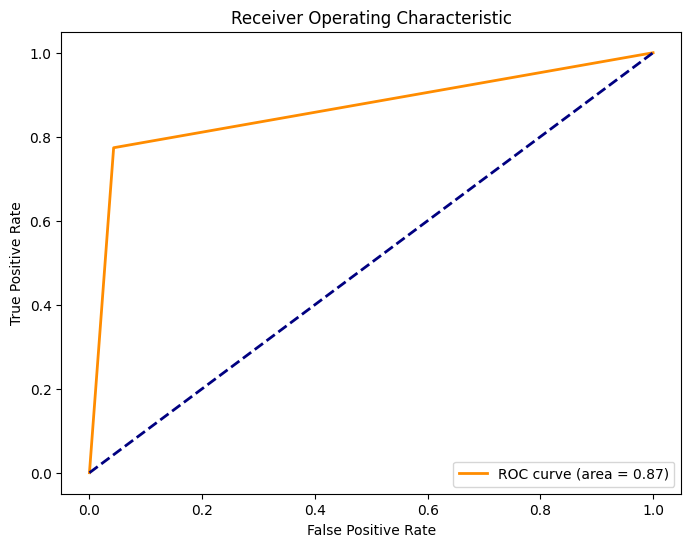

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have predictions and true labels
# y_true: true labels (0 or 1)
# y_pred: predicted probabilities of class 1

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Accuracy: 0.961415476444255
Recall: 0.3650697392359005
AUC: 0.67694664252132


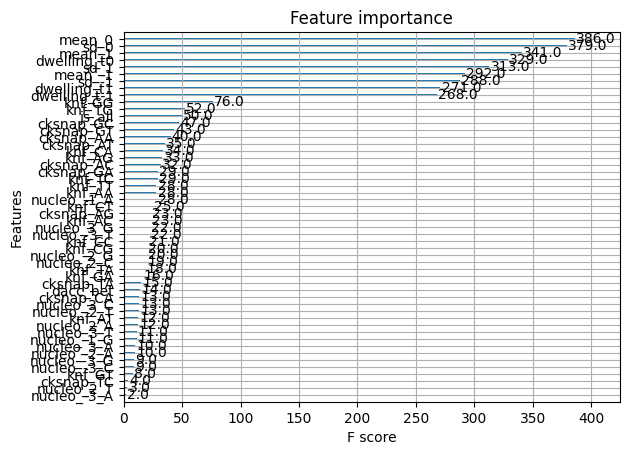

<Figure size 1600x1200 with 0 Axes>

In [56]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


X_train = df_train.drop(columns = ['label', 'gene_id', 'transcript_id', 'transcript_position'])
y_train = df_train.loc[:,'label']
X_test = df_test.drop(columns = ['label', 'gene_id', 'transcript_id', 'transcript_position'])
y_test = df_test.loc[:,'label']

clf = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Recall:", recall)
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print("AUC:", roc_auc)


xgb.plot_importance(clf)
plt.figure(figsize = (16, 12))
plt.show()

**AUC**

XGBoost: 0.62139238

SMOTE with XGBoost: 0.7637091

ADASYN with XGBoost: 0.76197441

SMOTE + Tomek with XGBoost: 0.7579971

SMOTE + ENN with XGBoost: 0.766277

**Recall**

XGBoost: 0.2441574

SMOTE with XGBoost: 0.602808

ADASYN with XGBoost: 0.6107099

SMOTE + Tomek with XGBoost: 0.62368257

SMOTE + ENN with XGBoost: 0.6303939

**AUC with position features**

XGBoost: 0.638654

SMOTE with XGBoost: 0.6614435

ADASYN with XGBoost: 0.6621789

SMOTE + Tomek with XGBoost: 0.6648953

SMOTE + ENN with XGBoost: 0.673170710

### AUC with all newly added features

XGBoost: 0.6281466721747095

SMOTE with XGBoost: 0.663617396

ADASYN with XGBoost: 0.6742077444

SMOTE + Tomek with XGBoost: 0.6667479

SMOTE + ENN with XGBoost: 0.6769466

In [ ]:
import xgboost as xgb

X_train = df_train.drop(columns = 'label')
y_train = df_train.loc[:,'label']
X_test = df_test.drop(columns = 'label')
y_test = df_test.loc[:,'label']

dtrain = xgb.DMatrix(X_train, label=y_train)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    nfold=5,  # Number of folds for cross-validation
    metrics='logloss',  # Evaluation metric
    early_stopping_rounds=10,  # Stop early if no improvement is observed
    stratified=True,  # Ensure class distribution is preserved in each fold
    seed=42,  # Random seed for reproducibility
)

print(cv_results)

    train-logloss-mean  train-logloss-std  test-logloss-mean  test-logloss-std
0             0.632424           0.000426           0.632535          0.000529
1             0.610598           0.000324           0.610771          0.000525
2             0.596020           0.000457           0.596247          0.000760
3             0.583667           0.000277           0.583939          0.000758
4             0.568290           0.000237           0.568611          0.000866
..                 ...                ...                ...               ...
95            0.315367           0.001421           0.318244          0.002225
96            0.314850           0.001399           0.317749          0.002236
97            0.314118           0.001352           0.317037          0.002121
98            0.313632           0.001264           0.316548          0.002154
99            0.313006           0.001323           0.315916          0.002155

[100 rows x 4 columns]


In [57]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

X_train = df_train.drop(columns = 'label')
y_train = df_train.loc[:,'label']
X_test = df_test.drop(columns = 'label')
y_test = df_test.loc[:,'label']

clf = xgb.XGBClassifier(random_state=4266, colsample_bytree = 0.8, colsample_bynode = 0.8, colsample_bylevel = 0.8, use_label_encoder = False,
                        eval_metric = "logloss", objective = "binary:logistic", n_estimators = 200)

params = {
 "learning_rate" : [0.03, 0.05, 0.08],
 "max_depth" : [5, 7, 10],
 "min_child_weight" : [1, 3, 5],
 "gamma": [0.5, 1],
 "alpha": [0, 0.5],
 "subsample": [0.8, 1],
 "n_estimators":[300, 500, 700]
}

gscv_model = GridSearchCV(clf, param_grid = params, verbose =3, cv=5, scoring = 'roc_auc', n_jobs=-1)
gscv_model.fit(X_train,y_train)

KeyboardInterrupt: ignored